<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Convolutional-Neural-Network" data-toc-modified-id="Convolutional-Neural-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Convolutional Neural Network</a></span><ul class="toc-item"><li><span><a href="#Load-and-process-training-data" data-toc-modified-id="Load-and-process-training-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load and process training data</a></span></li><li><span><a href="#Network-setup" data-toc-modified-id="Network-setup-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Network setup</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Save-the-trained-model" data-toc-modified-id="Save-the-trained-model-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Save the trained model</a></span></li></ul></li><li><span><a href="#Apply-trained-model-to-digital-elevation-dataset" data-toc-modified-id="Apply-trained-model-to-digital-elevation-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Apply trained model to digital elevation dataset</a></span><ul class="toc-item"><li><span><a href="#Export-labeled-image-as-georeferenced-tif" data-toc-modified-id="Export-labeled-image-as-georeferenced-tif-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Export labeled image as georeferenced tif</a></span></li></ul></li><li><span><a href="#Generate-maps-from-the-labeled-dataset" data-toc-modified-id="Generate-maps-from-the-labeled-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate maps from the labeled dataset</a></span></li></ul></div>

# Imports

In [1]:
## Tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Input,
    Convolution2D,
    MaxPooling2D,
    Dense,
    Dropout,
    Flatten,
)
from tensorflow.python.client import device_lib

## Matplotlib
from matplotlib import (
    pyplot as plt,
    cm,
    gridspec,
)
from matplotlib.patches import Rectangle
from matplotlib.colors import LightSource, ListedColormap, LinearSegmentedColormap

%matplotlib inline

## Misc
from IPython import display
import pylab as pl
from skimage.io import imread
from pathlib import Path
import sys, os
import seaborn as sns
import numpy as np
from osgeo import gdal
from gdalconst import GA_ReadOnly

PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT / "bahamas_gia"))
FIG_PATH = PROJECT_ROOT / "manuscript/figures/"

## From bahamas_gia repo.
from bahamas_gia.config import data_dir
from bahamas_gia.config import model_dir
from bahamas_gia.utils import (
    label_image,
    clear_edges,
)

## Default figure parameters
sns.set_palette("viridis", n_colors=6)
sns.set_style(
    "ticks",
    {
        "axes.edgecolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "axes.facecolor": "(.98,.98,.98)",
        "axes.grid": True,
        "grid.color": ".9",
        "grid.linestyle": u"-.",
    },
)
sns.set_context("talk")
plt.rc("text", usetex=True)
plt.rc("font", family="sans-serif")

Uncomment to check if tensorflow will use GPU (should list CPU and GPU devices):

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6651054353239245395
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16765615196544407486
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 799419438634622487
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10766545716
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4666421389356766229
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


# Convolutional Neural Network

## Load and process training data
The digital elevation data used in this project is not open source, but can be requested for scientific use through the protocols described at this link:

https://tandemx-science.dlr.de/

However, the CNN set up below can be adapted to any raster data.

In [4]:
# Load digital elevation dataset (tanDEMx is private, but could be your dataset of choice)
im = imread(str(data_dir) + "/processed/tDEM_clean_lo.tif")

# Load raster of labeled pixels
im_masks = imread(str(data_dir) + "/processed/training_data_points.tif")

im[im < -41] = -41  # Removes any noise in the non-land regions of our dataset'
im = (
    im + 41
)  # Sets the min elevation values closer to 0 for 0 to 1 normalization for the CNN.

side_size = 50  # size of contextual window

In [5]:
im_masks = clear_edges(
    im_masks, side_size
)  # removed any training data that falls close enough to
# the data edge that a full X by X square cannot be extracted


X, Y = np.where(im_masks == 1)  ##dune
training_data_X = np.array(
    [
        im[
            int(x - side_size / 2) : int(x + side_size / 2),
            int(y - side_size / 2) : int(y + side_size / 2),
        ]
        for x, y in zip(X, Y)
    ]
)
training_data_Y = np.array([[0] * training_data_X.shape[0]]).ravel()

X, Y = np.where(im_masks == 2)  ##5e flat
x2 = np.array(
    [
        im[
            int(x - side_size / 2) : int(x + side_size / 2),
            int(y - side_size / 2) : int(y + side_size / 2),
        ]
        for x, y in zip(X, Y)
    ]
)
y2 = np.array([[1] * x2.shape[0]]).ravel()

training_data_X = np.append(training_data_X, x2, axis=0)
training_data_Y = np.append(training_data_Y, y2).ravel()

X, Y = np.where(im_masks == 3)  ##holocene
x3 = np.array(
    [
        im[
            int(x - side_size / 2) : int(x + side_size / 2),
            int(y - side_size / 2) : int(y + side_size / 2),
        ]
        for x, y in zip(X, Y)
    ]
)
y3 = np.array([[2] * x3.shape[0]]).ravel()

training_data_X = np.append(training_data_X, x3, axis=0).reshape(
    -1, side_size, side_size, 1
)
training_data_Y = np.append(training_data_Y, y3).ravel()

In [6]:
# these lines shuffle the data
consistent_random = np.random.RandomState(seed=1)
order = consistent_random.choice(
    np.arange(0, training_data_Y.size), training_data_Y.size, replace=False
)
training_data_X = training_data_X[order, :, :, :]
training_data_Y = training_data_Y[order]

In [7]:
divide_by = np.max(training_data_X)
num_train, height, width, depth = training_data_X.shape
num_classes = np.unique(training_data_Y).shape[0]  # the number of unique image classes

training_data_X = training_data_X.astype("float32")
training_data_X /= divide_by  # Normalise data to [0, 1] range

training_data_Y = to_categorical(
    training_data_Y, num_classes
)  # One-hot encode the labels

## Network setup

In [8]:
batch_size = 32  # in each iteration, we consider 32 training examples at once
num_epochs = 200  # we iterate 200 times over the entire training set
kernel_size = 3  # we will use 3x3 kernels throughout
pool_size = 2  # we will use 2x2 pooling throughout
conv_depth_1 = 32  # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64  # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25  # dropout after pooling with probability 0.25
drop_prob_2 = 0.5  # dropout in the FC layer with probability 0.5
hidden_size = 512  # the FC layer will have 512 neurons

In [9]:
inp = Input(
    shape=(height, width, depth)
)  # depth goes last in TensorFlow back-end (first in Theano)
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Convolution2D(
    conv_depth_1, (kernel_size, kernel_size), padding="same", activation="relu"
)(inp)
conv_2 = Convolution2D(
    conv_depth_1, (kernel_size, kernel_size), padding="same", activation="relu"
)(conv_1)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
drop_1 = Dropout(drop_prob_1)(pool_1)
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
conv_3 = Convolution2D(
    conv_depth_2, (kernel_size, kernel_size), padding="same", activation="relu"
)(drop_1)
conv_4 = Convolution2D(
    conv_depth_2, (kernel_size, kernel_size), padding="same", activation="relu"
)(conv_3)
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
drop_2 = Dropout(drop_prob_1)(pool_2)
# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
flat = Flatten()(drop_2)
hidden = Dense(hidden_size, activation="relu")(flat)
drop_3 = Dropout(drop_prob_2)(hidden)
out = Dense(num_classes, activation="softmax")(drop_3)

model = Model(
    inputs=inp, outputs=out
)  # To define a model, just specify its input and output layers

model.compile(
    loss="categorical_crossentropy",  # using the cross-entropy loss function
    optimizer="adam",  # using the Adam optimiser
    metrics=["accuracy"],
)  # reporting the accuracy

## Train the model

In [10]:
K.set_value(model.optimizer.lr, 0.000015)  # adjust learning rate

In [11]:
# Arrays for tracking progress
acc = np.array([])
val_acc = np.array([])
loss = np.array([])

The following cell will generate loss and accuracy plots that update with each epoch

In [ ]:
fig = plt.figure(figsize=(12, 5))

acc = np.array([])
val_acc = np.array([])
loss = np.array([])

log = model.fit(
    training_data_X,
    training_data_Y,
    batch_size=batch_size,
    epochs=1,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
)

loss = np.append(loss, log.history["loss"])
acc = np.append(acc, log.history["accuracy"])
val_acc = np.append(val_acc, log.history["val_accuracy"])

acc_plot = plt.subplot(1, 2, 1)
loss_plot = plt.subplot(1, 2, 2)

for i in range(1, 15000):  # for N epochs
    log = model.fit(
        training_data_X,
        training_data_Y,
        batch_size=batch_size,
        epochs=1,
        verbose=0,
        validation_split=0.1,
        shuffle=True,
    )

    loss = np.append(loss, log.history["loss"])
    acc = np.append(acc, log.history["accuracy"])
    val_acc = np.append(val_acc, log.history["val_accuracy"])

    acc_plot.plot(
        [1 + i - 1, 1 + i],
        100 * np.array([acc[-2], acc[-1]]),
        color=(0.2, 0.2, 0.2),
        lw=1,
    )
    acc_plot.plot(
        [1 + i - 1, 1 + i],
        100 * np.array([val_acc[-2], val_acc[-1]]),
        color=(0.7, 0.2, 0.2),
        lw=1,
    )
    acc_plot.set_xlabel("Epoch")
    acc_plot.set_ylabel("Accuracy")
    acc_plot.set_title(
        "Current validation accuracy " + str(np.round(val_acc[-1] * 100, 1)) + "\%"
    )

    loss_plot.plot(
        [1 + i - 1, 1 + i], np.log([loss[-2], loss[-1]]), color=(0.2, 0.2, 0.2), lw=1
    )
    loss_plot.set_xlabel("Epoch")
    loss_plot.set_ylabel("log loss")
    loss_plot.set_title("Current value " + str(np.round(np.log(loss[-1]), 3)))

    fig.tight_layout()

    display.display(pl.gcf())
    display.clear_output(wait=True)

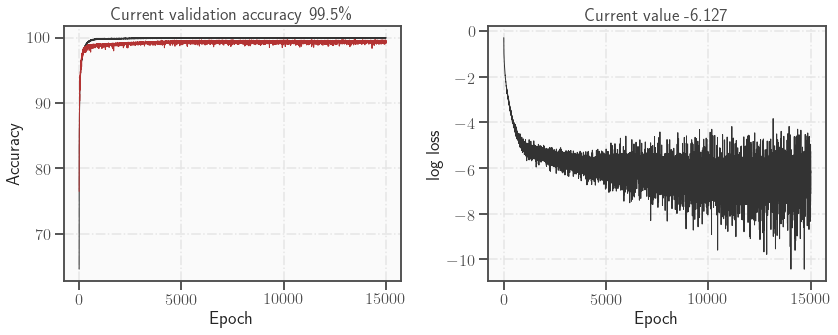

In [14]:
fig = plt.figure(figsize=(12, 5))


acc_plot = plt.subplot(1, 2, 1)
loss_plot = plt.subplot(1, 2, 2)
x_r = np.arange(acc.size)

acc_plot.plot(
    x_r, 100 * np.array(acc), color=(0.2, 0.2, 0.2), lw=1,
)
acc_plot.plot(
    x_r, 100 * np.array(val_acc), color=(0.7, 0.2, 0.2), lw=1,
)
acc_plot.set_xlabel("Epoch")
acc_plot.set_ylabel("Accuracy")
acc_plot.set_title(
    "Current validation accuracy " + str(np.round(val_acc[-1] * 100, 1)) + "\%"
)

loss_plot.plot(x_r, np.log(loss), color=(0.2, 0.2, 0.2), lw=1)
loss_plot.set_xlabel("Epoch")
loss_plot.set_ylabel("log loss")
loss_plot.set_title("Current value " + str(np.round(np.log(loss[-1]), 3)))

fig.tight_layout()

## Save the trained model

In [ ]:
# filename includes divide_by -- the normalizing factor needed for future labeling

save_name = str(len(acc)) + "_epochs_" + str(divide_by) + "_.h5"
model.save(str(data_dir) + "/cnn/" + save_name)

# Apply trained model to digital elevation dataset

In [4]:
# list saved models
files = os.listdir(str(data_dir) + "/cnn/")
print(files)

['5845_epochs_70.h5', '12748_epochs_70.h5', '15000_epochs_69.80905_.h5', '4935_epochs_70.h5']


In [6]:
# select one to load
to_load = files[2]
print("Loading " + to_load)
model = load_model(str(data_dir) + "/cnn/" + to_load)

Loading 15000_epochs_69.80905_.h5


In [7]:
im = imread(
    str(data_dir) + "/processed/tDEM_clean_lo.tif"
)  # Load Digital elevation data

# The next two lines must be the same as you performed on the data during 2.1 Load and process

im[im < -41] = -41  # Removes any noise in the non-land regions of our dataset'
im = (
    im + 41
)  # Sets the min elevation values closer to 0 for 0 to 1 normalization for the CNN.

In [8]:
divide_by = float(to_load.split("_")[2])
L = label_image(
    im, divide_by, model, memory_buffer=10000
)  # decrease memory buffer if you are running out of RAM

finished chunk #1394 out of 1394


## Export labeled image as georeferenced tif

In [9]:
## set arr_out to the labeled image
arr_out = L + 1  # + 1 sets the -1 water to 0.

## load original dataset with gdal
ds = gdal.Open(str(data_dir) + "/processed/tDEM_clean_lo.tif", GA_ReadOnly)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()

[cols, rows] = arr.shape

driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(
    str(data_dir) + "/processed/labeled_georaster.tif", rows, cols, 1, gdal.GDT_UInt16
)
outdata.SetGeoTransform(ds.GetGeoTransform())  ##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())  ##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(0)  ##if you want these values transparent
outdata.FlushCache()  ##saves to disk!!
outdata = None
band = None
ds = None

# Generate maps from the labeled dataset

Load labeled image

In [17]:
ds = gdal.Open(str(data_dir) + "/processed/labeled_georaster.tif", GA_ReadOnly)
band = ds.GetRasterBand(1)
L = band.ReadAsArray()

ulx, xres, xskew, uly, yskew, yres = ds.GetGeoTransform()
lrx = ulx + (ds.RasterXSize * xres)
lry = uly + (ds.RasterYSize * yres)
map_coord_extent = [ulx, lrx, lry, uly]

band = None
ds = None

L = L - 1

Set up map properties and bounds

In [18]:
holocene_color = "#c5b8a9"
dune_color = "#4f7203"
lig_color = "#848a8c"
water_color = "white"

# make a color map of fixed colors
cmap = ListedColormap([water_color, dune_color, lig_color, holocene_color])

cdict = {
    "red": ((0.0, 1.0, 1.0), (1.0, 0.0, 0.0)),
    "green": ((0.0, 1.0, 1.0), (1.0, 0.0, 0.0)),
    "blue": ((0.0, 1.0, 1.0), (1.0, 0.0, 0.0)),
    "alpha": ((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
transparent = LinearSegmentedColormap("custom", cdict)  # used for the shape edge lines

Ex = (slice(13250, 14500), slice(10250, 12500))
Ele = (slice(6600, 10100), slice(7000, 10500))
Long = (slice(13250, 16500), slice(12750, 15000))
Cat = (slice(9750, 12000), slice(11300, 13200))
Ack = (slice(16400, 19100), slice(16000, 18500))
Ina = (slice(21800, 23500), slice(18600, 21500))
SS = (slice(11750, 12550), slice(15650, 16200))
Caicos = (slice(19500, 21500), slice(23000, 27000))
Abaco = (slice(1500, 5800), slice(4000, 7000))
AndrosN = (slice(7800, 11700), slice(1200, 4900))
AndrosS = (slice(11700, 13700), slice(3200, 5200))
Grand = (slice(1500, 3500), slice(0, 4000))
Maya = (slice(17700, 18500), slice(20600, 22400))
NP = (slice(8200, 8900), slice(4850, 6050))

maps = {}
maps["Ex"] = [Ex, "Great Exuma", (0.02, 0.35), (0.02, 0.02), "left", "bottom", 1]
maps["Ele"] = [Ele, "Eleuthera", (0.98 - 0.075, 0.9), (0.98, 0.98), "right", "top", 0]
maps["Long"] = [Long, "Long Island", (0.02, 0.15), (0.02, 0.02), "left", "bottom", 1]
maps["Cat"] = [Cat, "Cat Island", (0.02, 0.15), (0.02, 0.02), "left", "bottom", 1]
maps["Ack"] = [
    Ack,
    "Crooked and Acklins Islands",
    (0.98 - 0.075, 0.15),
    (0.98, 0.02),
    "right",
    "bottom",
    0,
]
maps["Ina"] = [Ina, "Great Inagua", (0.02, 1 - 0.15), (0.02, 0.98), "left", "top", 1]
maps["SS"] = [
    SS,
    "San Salvador Island",
    (0.98 - 0.075, 0.15),
    (0.98, 0.02),
    "right",
    "bottom",
    0,
]
maps["Caicos"] = [
    Caicos,
    "Turks and Caicos",
    (0.02, 0.25),
    (0.02, 0.02),
    "left",
    "bottom",
    1,
]
maps["Abaco"] = [Abaco, "Great Abaco", (0.02, 0.15), (0.02, 0.02), "left", "bottom", 1]
maps["AndrosN"] = [
    AndrosN,
    "North Andros Island",
    (0.02, 0.15),
    (0.02, 0.02),
    "left",
    "bottom",
    1,
]
maps["AndrosS"] = [
    AndrosS,
    "South Andros Island",
    (0.02, 0.15),
    (0.02, 0.02),
    "left",
    "bottom",
    1,
]
maps["Grand"] = [
    Grand,
    "Grand Bahama",
    (0.02, 1 - 0.15),
    (0.02, 0.98),
    "left",
    "top",
    1,
]
maps["Maya"] = [
    Maya,
    "Mayaguana",
    (0.98 - 0.075, 0.82),
    (0.98, 0.98),
    "right",
    "top",
    0,
]
maps["NP"] = [
    NP,
    "New Providence Island",
    (0.02, 1 - 0.15),
    (0.02, 0.98),
    "left",
    "top",
    1,
]

The next cell generates maps for each island region above and places them in the maps directory of the repository (overwriting any files already present).

In [19]:
%%capture

ls = LightSource(azdeg=45, altdeg=15)

for map_id in list(maps):
    R = maps[map_id][0]
    map_name = maps[map_id][1]
    legend = maps[map_id][2]
    t_off = 0.075 + 0.01
    offset = 0.04

    title_x = maps[map_id][3][0]
    title_y = maps[map_id][3][1]
    title_halign = maps[map_id][4]
    title_valign = maps[map_id][5]
    l_or_r = maps[map_id][6]

    sub_map_extent = (
        np.linspace(map_coord_extent[0], map_coord_extent[1], rows)[
            maps[map_id][0][1].start
        ],
        np.linspace(map_coord_extent[0], map_coord_extent[1], rows)[
            maps[map_id][0][1].stop
        ],
        np.linspace(map_coord_extent[3], map_coord_extent[2], cols)[
            maps[map_id][0][0].stop
        ],
        np.linspace(map_coord_extent[3], map_coord_extent[2], cols)[
            maps[map_id][0][0].start
        ],
    )

    fig = plt.figure(figsize=(8.5, 11))
    rgb_region = cmap((L[R] + 1) / 3)
    z = im[R]
    lines = np.sum(np.abs(np.gradient(L[R])), axis=0)
    lines[lines > 0] = 1
    plt.imshow(
        ls.blend_soft_light(
            rgb_region[:, :, :3],
            ls.hillshade(z, vert_exag=0.25, dx=1, dy=1)[:, :, np.newaxis],
        ),
        extent=sub_map_extent,
    )
    plt.imshow(
        lines,
        cmap=transparent,
        vmin=0,
        vmax=1,
        interpolation="Gaussian",
        extent=sub_map_extent,
    )
    plt.text(
        title_x,
        title_y,
        map_name,
        transform=plt.gca().transAxes,
        fontsize=25,
        horizontalalignment=title_halign,
        verticalalignment=title_valign,
    )

    patch = Rectangle(
        legend,
        0.075,
        0.025,
        angle=0.0,
        transform=plt.gca().transAxes,
        color=holocene_color,
        ec=(0.2, 0.2, 0.2),
        lw=1,
    )
    plt.text(
        legend[0] + (l_or_r * t_off) - ((1 - l_or_r) * 0.01),
        legend[1] + 0.025 / 2,
        "Holocene sediments",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="center",
        horizontalalignment=title_halign,
    )
    plt.gca().add_patch(patch)

    patch = Rectangle(
        (legend[0], legend[1] - offset),
        0.075,
        0.025,
        angle=0.0,
        transform=plt.gca().transAxes,
        color=lig_color,
        ec=(0.2, 0.2, 0.2),
        lw=1,
    )
    plt.text(
        legend[0] + (l_or_r * t_off) - ((1 - l_or_r) * 0.01),
        legend[1] - offset + 0.025 / 2,
        "LIG flats",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="center",
        horizontalalignment=title_halign,
    )
    plt.gca().add_patch(patch)

    patch = Rectangle(
        (legend[0], legend[1] - 2 * offset),
        0.075,
        0.025,
        angle=0.0,
        transform=plt.gca().transAxes,
        color=dune_color,
        ec=(0.2, 0.2, 0.2),
        lw=1,
    )
    plt.text(
        legend[0] + (l_or_r * t_off) - ((1 - l_or_r) * 0.01),
        legend[1] - 2 * offset + 0.025 / 2,
        "Dunes",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="center",
        horizontalalignment=title_halign,
    )
    plt.gca().add_patch(patch)
    plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
    plt.gca().set_xlabel("Longitude ($^{\circ}$E)")
    plt.gca().tick_params(axis="both", which="major", labelsize=12)

    plt.grid(False)
    fig.savefig(
        str(PROJECT_ROOT) + "/maps/" + map_id + ".pdf", bbox_inches="tight", dpi=600
    )